In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
data = pd.read_csv('train.csv')

numeric_data = data.drop(['record_id', 'earliest_cr_line', 'issue_d', 'zip_code', 'policy_code'], axis=1)
# numeric_data = numeric_data.sort_values(['emp_length'])
numeric_data['term'] = pd.factorize(numeric_data['term'])[0]
numeric_data['emp_length'] = numeric_data['emp_length'].map({'< 1 year': 0, '1 year':1, '2 years':2,  '3 years':3,  '4 years':4,  '5 years':5,  '6 years':6,  '7 years':7,  '8 years':8,  '9 years':9,  '10+ years': 10})
numeric_data['emp_length'].fillna(0, inplace=True)

numeric_data['verification_status'] = numeric_data['verification_status'].map({'Not Verified': 0, 'Verified': 1, 'Source Verified': 2})

numeric_data['emp_title'].fillna('0', inplace=True)

numeric_data['mths_since_last_delinq'].fillna(numeric_data['mths_since_last_delinq'].notnull().mean(), inplace=True)
numeric_data['collections_12_mths_ex_med'].fillna(numeric_data['collections_12_mths_ex_med'].notnull().mean(), inplace=True)
numeric_data['revol_util'].fillna(numeric_data['revol_util'].notnull().mean(), inplace=True)
numeric_data['application_type'] = pd.factorize(numeric_data['application_type'])[0]
numeric_data['initial_list_status'] = pd.factorize(numeric_data['initial_list_status'])[0]
numeric_data['addr_state'] = pd.factorize(numeric_data['addr_state'])[0]

numeric_data['tot_coll_amt'].fillna(numeric_data['tot_coll_amt'].notnull().max(), inplace=True)
numeric_data['tot_cur_bal'].fillna(numeric_data['tot_cur_bal'].notnull().max(), inplace=True)
numeric_data['total_rev_hi_lim'].fillna(numeric_data['total_rev_hi_lim'].notnull().max(), inplace=True)

data['verification_status'].value_counts()

Verified           73431
Not Verified       66943
Source Verified    59815
Name: verification_status, dtype: int64

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# numeric_data[numeric_data['loan_status'] > 0.5] = 1  
le = LabelEncoder()
# print(str(numeric_data['grade'].values))
numeric_data[numeric_data['grade'] == 0] = '0'
le.fit(numeric_data.grade.astype(str))
# print(le.classes_)
# numeric_data.info()
numeric_data['grade_le'] = le.transform((numeric_data['grade'].values))

le.fit(numeric_data.sub_grade.astype(str))
numeric_data['sub_grade_le'] = le.transform(numeric_data['sub_grade'].values)

le.fit(numeric_data.emp_title.astype(str))
numeric_data['emp_title_le'] = le.transform(numeric_data['emp_title'].values)

# le.fit(numeric_data.addr_state.astype(str))
# numeric_data['addr_state_le'] = le.transform(numeric_data['addr_state'].values)

le.fit(numeric_data.pymnt_plan.astype(str))
numeric_data['pymnt_plan_le'] = le.transform(numeric_data['pymnt_plan'].values)

le.fit(numeric_data.purpose.astype(str))
numeric_data['purpose_le'] = le.transform(numeric_data['purpose'].values)

ohe = OneHotEncoder()
new_ohe_features = ohe.fit(numeric_data.home_ownership.values.reshape(-1, 1))
data['home_ownership_ohe'] = ohe.transform(numeric_data.home_ownership.values.reshape(-1, 1))

numeric_data = numeric_data.drop(['grade', 'sub_grade',  'purpose', 'emp_title', 'pymnt_plan', 'home_ownership'], axis=1)



In [5]:
X = numeric_data.drop(['loan_status'], axis=1)
y = numeric_data['loan_status']
# numeric_data['loan_status'].value_counts()

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_resample(X, y)
# y

In [6]:
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

model_l1 = LogisticRegression(penalty='l1')
model_l2 = LogisticRegression(penalty='l2')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
model_l1.fit(X_train, y_train)
model_l2.fit(X_train, y_train)

C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\NikitsinskayaH\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [9]:
preds_l1 = model_l1.predict(X_test)
preds_l2 = model_l2.predict(X_test)

In [10]:
from sklearn import metrics


preds = model_l1.predict(X_test)
print(preds)
conf_matrix = metrics.confusion_matrix(y_test, preds)
conf_matrix = pd.DataFrame(conf_matrix, index=model_l1.classes_)

[0 1 1 ... 1 1 1]


In [11]:
conf_matrix

,0,1
0,29852,16781
1,15916,30848


In [12]:
preds = model_l2.predict(X_test)

conf_matrix = metrics.confusion_matrix(y_test, preds)
conf_matrix = pd.DataFrame(conf_matrix, index=model_l2.classes_)

In [13]:
conf_matrix

,0,1
0,30557,16076
1,17087,29677


In [14]:
pred_prob_l1 = model_l1.predict_proba(X_test)
preds = pred_prob_l1[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(pred_prob_l1)

[[0.59169581 0.40830419]
 [0.25376279 0.74623721]
 [0.37198817 0.62801183]
 ...
 [0.37159714 0.62840286]
 [0.23274817 0.76725183]
 [0.27597778 0.72402222]]


0.7045016757323641
0.6927572540726039


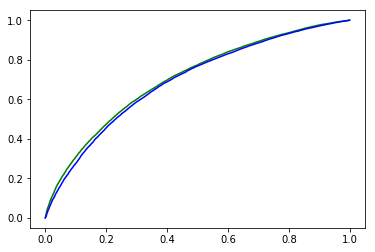

In [15]:
print(roc_auc)
plt.plot(fpr, tpr, 'g')
pred_prob_l2 = model_l2.predict_proba(X_test)
preds = pred_prob_l2[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)
plt.plot(fpr, tpr, 'b')
plt.show()